In [1]:
# default_exp fitting

# Comparing InstanceCMR and PrototypeCMR Using the Murdock (1962) Dataset
The main purposes of performing comparisons using the Murdock (1962) dataset is to examine whether both models (here, CMR and InstanceCMR) can adequately account for performance across trial list lengths with a common parameter configuration. Let's review the results here.

In [1]:
from compmemlearn.fitting import murdock_objective_function, apply_and_concatenate
from compmemlearn.models import Classic_CMR, Instance_CMR
from compmemlearn.datasets import prepare_murdock1962_data

murd_trials0, murd_events0, murd_length0 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 0)
murd_trials1, murd_events1, murd_length1 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 1)
murd_trials2, murd_events2, murd_length2 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 2)
murd_events0.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


## Across-Subject Fits

### PrototypeCMR Fitting

In [2]:
from scipy.optimize import differential_evolution
from numba.typed import List
from numba import njit
import numpy as np

free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]


# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_objective_function(
    List([murd_trials0, murd_trials1, murd_trials2]),  
    List([murd_length0, murd_length1, murd_length2]),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

cmr_result = differential_evolution(cost_function, bounds, disp=True)
print(cmr_result)


differential_evolution step 1: f(x)= 135958
differential_evolution step 2: f(x)= 125655
differential_evolution step 3: f(x)= 103570
differential_evolution step 4: f(x)= 103570
differential_evolution step 5: f(x)= 100461
differential_evolution step 6: f(x)= 95791.8
differential_evolution step 7: f(x)= 95791.8
differential_evolution step 8: f(x)= 89452.9
differential_evolution step 9: f(x)= 88157.3
differential_evolution step 10: f(x)= 88157.3
differential_evolution step 11: f(x)= 88157.3
differential_evolution step 12: f(x)= 88157.3
differential_evolution step 13: f(x)= 85599.8
differential_evolution step 14: f(x)= 85599.8
differential_evolution step 15: f(x)= 85599.8
differential_evolution step 16: f(x)= 84121
differential_evolution step 17: f(x)= 82701.2
differential_evolution step 18: f(x)= 82701.2
differential_evolution step 19: f(x)= 82701.2
differential_evolution step 20: f(x)= 82178.5
differential_evolution step 21: f(x)= 82178.5
differential_evolution step 22: f(x)= 82178.5
diff

```
     fun: 80256.44589909283
     jac: array([-2.91038303e-01, -6.08270057e-01,  1.23691279e-01,  1.01572368e+00,
       -1.45172816e+02,  1.23691280e-01, -4.07453629e-02,  0.00000000e+00,
        1.31592969e+01,  4.30445653e+00, -9.16770665e-02,  2.41694215e+02])
 message: 'Optimization terminated successfully.'
    nfev: 9018
     nit: 40
 success: True
       x: array([6.29776961e-01, 8.36605136e-02, 8.14625349e-01, 1.78604741e-01,
       1.00000000e+00, 1.41520577e-01, 6.36256484e+00, 5.61742567e+01,
       2.40357573e-02, 2.61868291e-01, 3.50092609e+00, 2.22044605e-16])
```

Now we compute the SPC, CRP, and PFR stats associated with these model fits, contrasted against the actual data. We'll have to compute separate stats for each list length.

In [3]:
from compmemlearn.datasets import simulate_data
from numba.typed import Dict
from numba.core import types
import pandas as pd
from psifr import fr

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model0 = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
model1 = Classic_CMR(murd_length1, murd_length1, fitted_parameters)
model2 = Classic_CMR(murd_length2, murd_length2, fitted_parameters)

sim_df0 = simulate_data(model0, 1000)
sim_df1 = simulate_data(model1, 1000)
sim_df2 = simulate_data(model2, 1000)
true_df0 = murd_events0.copy()
true_df1 = murd_events1.copy()
true_df2 = murd_events2.copy()

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['PrototypeCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

cmr_spc1 = apply_and_concatenate(fr.spc, sim_df1, true_df1, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp1 = apply_and_concatenate(fr.lag_crp, sim_df1, true_df1, 'source', ['PrototypeCMR', 'data'])
cmr_pfr1 = apply_and_concatenate(fr.pnr, sim_df1, true_df1, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr1 = cmr_pfr1.query('output <= 1')

cmr_spc2 = apply_and_concatenate(fr.spc, sim_df2, true_df2, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp2 = apply_and_concatenate(fr.lag_crp, sim_df2, true_df2, 'source', ['PrototypeCMR', 'data'])
cmr_pfr2 = apply_and_concatenate(fr.pnr, sim_df2, true_df2, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr2 = cmr_pfr2.query('output <= 1')

### InstanceCMR Fitting

In [4]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'delay_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
#    'context_sensitivity',
#    'feature_sensitivity'
]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Instance_CMR(item_count, presentation_count, parameters)

cost_function = murdock_objective_function(
    List([murd_trials0, murd_trials1, murd_trials2]),  
    List([murd_length0, murd_length1, murd_length2]),
    init_icmr,
    {'context_sensitivity': 1, 'feature_sensitivity': 1}, 
    free_parameters)

icmr_result = differential_evolution(cost_function, bounds, disp=True)
print(icmr_result)

differential_evolution step 1: f(x)= 184651
differential_evolution step 2: f(x)= 102310
differential_evolution step 3: f(x)= 102310
differential_evolution step 4: f(x)= 100863
differential_evolution step 5: f(x)= 99779.4
differential_evolution step 6: f(x)= 99779.4
differential_evolution step 7: f(x)= 98203.1
differential_evolution step 8: f(x)= 95897
differential_evolution step 9: f(x)= 95331.8
differential_evolution step 10: f(x)= 95331.8
differential_evolution step 11: f(x)= 95331.8
differential_evolution step 12: f(x)= 95331.8
differential_evolution step 13: f(x)= 95331.8
differential_evolution step 14: f(x)= 95331.8
differential_evolution step 15: f(x)= 95331.8
differential_evolution step 16: f(x)= 95331.8
differential_evolution step 17: f(x)= 95331.8
differential_evolution step 18: f(x)= 95331.8
differential_evolution step 19: f(x)= 95192.3
differential_evolution step 20: f(x)= 95120.7
differential_evolution step 21: f(x)= 94402.8
differential_evolution step 22: f(x)= 94322.4
dif

```
     fun: 80349.73620635353
     jac: array([ 6.29079292e+00, -1.33892172e+01,  3.29746397e+00, -4.32744855e+01,
       -6.52100422e+01, -7.01256795e+00, -2.91038280e-02,  0.00000000e+00,
       -1.00248144e+01,  5.06406650e-01,  3.06317817e+00])
 message: 'Optimization terminated successfully.'
    nfev: 13164
     nit: 59
 success: True
       x: array([7.66747592e-01, 1.68847562e-03, 8.46922217e-01, 4.25187058e-03,
       1.00000000e+00, 2.07232433e-01, 8.68402303e+00, 5.53375476e+01,
       2.40297656e-02, 2.61885572e-01, 1.29423172e+00])
```

In [6]:
fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(icmr_result.x)):
    fitted_parameters[free_parameters[i]] = icmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['choice_sensitivity'] = 1
fitted_parameters['feature_sensitivity'] = 1

model0 = Instance_CMR(murd_length0, murd_length0, fitted_parameters)
model1 = Instance_CMR(murd_length1, murd_length1, fitted_parameters)
model2 = Instance_CMR(murd_length2, murd_length2, fitted_parameters)

sim_df0 = simulate_data(model0, 1000)
sim_df1 = simulate_data(model1, 1000)
sim_df2 = simulate_data(model2, 1000)
true_df0 = murd_events0.copy()
true_df1 = murd_events1.copy()
true_df2 = murd_events2.copy()

icmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['InstanceCMR', 'data'])
icmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr0 = icmr_pfr0.query('output <= 1')

icmr_spc1 = apply_and_concatenate(fr.spc, sim_df1, true_df1, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp1 = apply_and_concatenate(fr.lag_crp, sim_df1, true_df1, 'source', ['InstanceCMR', 'data'])
icmr_pfr1 = apply_and_concatenate(fr.pnr, sim_df1, true_df1, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr1 = icmr_pfr1.query('output <= 1')

icmr_spc2 = apply_and_concatenate(fr.spc, sim_df2, true_df2, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp2 = apply_and_concatenate(fr.lag_crp, sim_df2, true_df2, 'source', ['InstanceCMR', 'data'])
icmr_pfr2 = apply_and_concatenate(fr.pnr, sim_df2, true_df2, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr2 = icmr_pfr2.query('output <= 1')

In [7]:
icmr_spc = pd.concat([icmr_spc0, icmr_spc1, icmr_spc2], 
    keys=[str(murd_length0), str(murd_length1), str(murd_length2)], 
    names=['List Length']).reset_index()
icmr_spc.drop(['level_1'], axis=1, inplace=True)

icmr_spc.head()

,List Length,source,subject,input,recall
0,20,InstanceCMR,0,1,1.0
1,20,InstanceCMR,0,2,0.0
2,20,InstanceCMR,0,3,1.0
3,20,InstanceCMR,0,4,0.0
4,20,InstanceCMR,0,5,0.0


### Visualization
This is a bit tricky. We want to plot the PFR, CRP, and SPC for each list length and for each model. Could maybe use different colors for list lengths but vary line styles to distinguish the data from the model? Let's try just a serial position curve first.

#### InstanceCMR

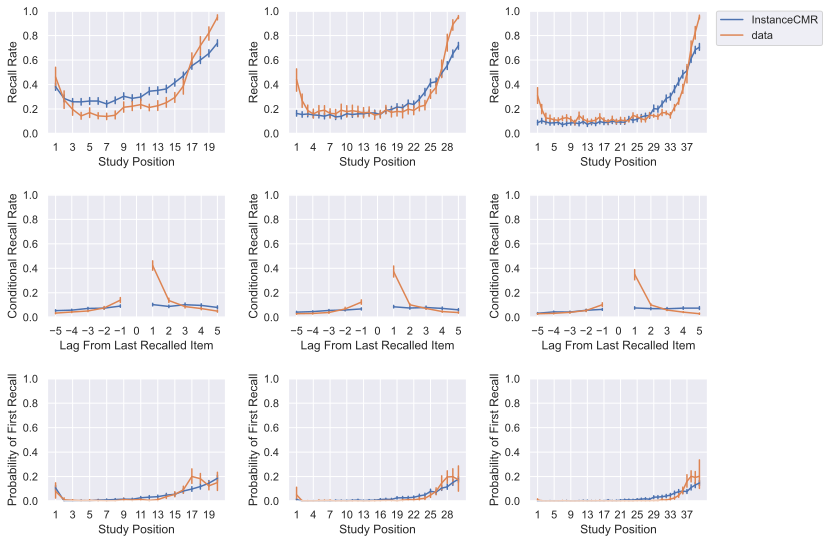

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12/1.5), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=icmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 1], data=icmr_spc1, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 2], data=icmr_spc2, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0, 2].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[0, 2].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1, 0], data=icmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 0], data=icmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 0].set_xticks(np.arange(-5, 6, 1))
axes[1, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=icmr_lag_crp1.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=icmr_lag_crp1.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel="Lag From Last Recalled Item", ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 2], data=icmr_lag_crp2.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 2], data=icmr_lag_crp2.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 2].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 2].set_xticks(np.arange(-5, 6, 1))
axes[1, 2].set_ylim((0, 1))

# pfr
sns.lineplot(data=icmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2, 0], hue='source', legend=False)
axes[2, 0].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[2, 0].set_ylim((0, 1))

sns.lineplot(data=icmr_pfr1, x='input', y='prob', err_style='bars', ax=axes[2, 1], hue='source', legend=False)
axes[2, 1].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[2, 1].set_ylim((0, 1))

sns.lineplot(data=icmr_pfr2, x='input', y='prob', err_style='bars', ax=axes[2, 2], hue='source', legend=False)
axes[2, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[2, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)
plt.savefig('icmr_summary_murdock1962.pdf', bbox_inches="tight")

#### CMR

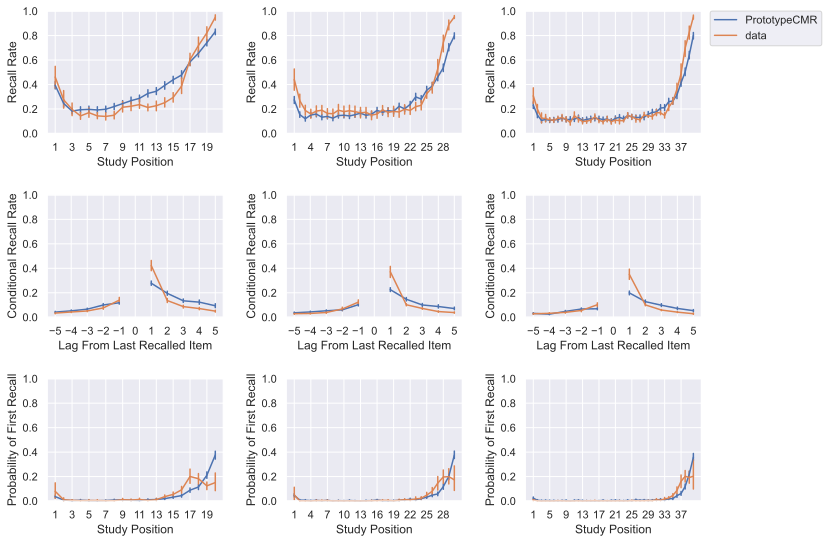

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12/1.5), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 1], data=cmr_spc1, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 2], data=cmr_spc2, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0, 2].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[0, 2].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1, 0], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 0], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 0].set_xticks(np.arange(-5, 6, 1))
axes[1, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp1.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp1.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel="Lag From Last Recalled Item", ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 2], data=cmr_lag_crp2.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 2], data=cmr_lag_crp2.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 2].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 2].set_xticks(np.arange(-5, 6, 1))
axes[1, 2].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2, 0], hue='source', legend=False)
axes[2, 0].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[2, 0].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr1, x='input', y='prob', err_style='bars', ax=axes[2, 1], hue='source', legend=False)
axes[2, 1].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[2, 1].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr2, x='input', y='prob', err_style='bars', ax=axes[2, 2], hue='source', legend=False)
axes[2, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[2, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)
plt.savefig('cmr_summary_murdock1962.pdf', bbox_inches="tight")

## Individual-Level Fitting

In [10]:

free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

subject_trial_count = 80 # Each subject gets 80 trials/lists a piece.
individual_cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count], murd_trials1[start_index:start_index+subject_trial_count], murd_trials2[start_index:start_index+subject_trial_count]]), 
        List([murd_length0, murd_length1, murd_length2]),
        init_cmr,
        {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
        free_parameters)

    individual_cmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(individual_cmr_results[-1].fun)

0 0
4473.204472643041
1 80
5663.93008844531
2 160
5285.501055815537
3 240
5266.5979848896
4 320
5571.197347032748
5 400
5803.635209004414
6 480
4905.063349138003
7 560
4472.107289557356
8 640
4833.9743135522685
9 720
5499.25451261045
10 800
4737.564552825974
11 880
5302.568498282828
12 960
5990.095337475669
13 1040
6393.844400445521
14 1120
5368.385508716119


In [12]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'delay_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
]

subject_trial_count = 80 # Each subject gets 20 trials/lists a piece.
individual_icmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
    List([murd_trials0[start_index:start_index+subject_trial_count], 
        murd_trials1[start_index:start_index+subject_trial_count], 
        murd_trials2[start_index:start_index+subject_trial_count]]),  
    List([murd_length0, murd_length1, murd_length2]),
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    free_parameters)

    individual_icmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(individual_icmr_results[-1].fun)

0 0
4787.91396295033
1 80
6040.464877039018
2 160


KeyboardInterrupt: 

In [ ]:
individual_fits = [result.fun for result in individual_cmr_results] + [result.fun for result in individual_icmr_results]
labels = ['PrototypeCMR'] * len(individual_cmr_results) + ['InstanceCMR'] * len(individual_icmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

In [ ]:
print(pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown())

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |        15     |         15     |
| mean  |      5317.45  |       5304.47  |
| std   |       542.658 |        549.988 |
| min   |      4474.12  |       4472.28  |
| 25%   |      4876.51  |       4869.52  |
| 50%   |      5357.38  |       5302.04  |
| 75%   |      5637.49  |       5614.51  |
| max   |      6389.25  |       6391.97  |


### Visualization

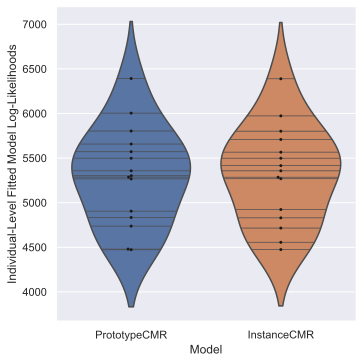

In [ ]:
sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
plt.savefig('individual_murdock1962.pdf', bbox_inches="tight")

In [ ]:
murd_events0

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False
...,...,...,...,...,...,...,...,...,...
23995,15,80,16,16,1.0,True,True,0,False
23996,15,80,17,17,NaN,True,False,0,False
23997,15,80,18,18,NaN,True,False,0,False
23998,15,80,19,19,2.0,True,True,0,False
